In [26]:
import mesa
import seaborn as sns
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

In [45]:
class MoneyAgent(mesa.Agent):
    """An Agent with fixed inital Wealth"""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

        self.wealth = 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = True,
            include_center = False,
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates.pop(cellmates.index(self))  # Ensure agent is not giving money to itself
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):
    """A Model with some number of Agents"""

    def __init__(self, N, width, height):
        self.num_agents = N

        # create scheduler
        self.schedule = mesa.time.RandomActivation(self)

        # create grtid
        self.grid = mesa.space.MultiGrid(width, height, True)

        # create data collector
        self.datacollector = mesa.DataCollector(
            model_reporters = {"Gini": self.compute_gini}, 
            agent_reporters = {"Wealth": "wealth"}
        )

        # variable for conditional shutoff of batch_run
        self.running = True
        
        # create agents
        for i in range(self.num_agents):
            agent = MoneyAgent(i, self)

            # add agent to scheduler
            self.schedule.add(agent)

            # add agent to grid
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

        
    def compute_gini(self):
        agent_wealths = [agent.wealth for agent in self.schedule.agents]
        x = sorted(agent_wealths)
        N = self.num_agents
        B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
        return 1 + (1 / N) - 2 * B

    def step(self):
        """Advance model by one step"""

        self.schedule.step()

        # collect data
        self.datacollector.collect(self)

In [35]:
# run model with 100 agents in a 10x10 grid for 100 steps
model = MoneyModel(100, 10, 10)
for i in range(100):
    model.step()

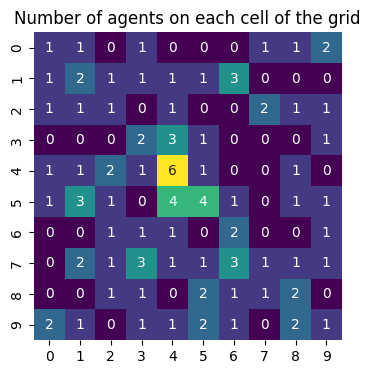

In [36]:
# plot agent counts
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
# Plot using seaborn, with a size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(4, 4)
g.set(title="Number of agents on each cell of the grid");


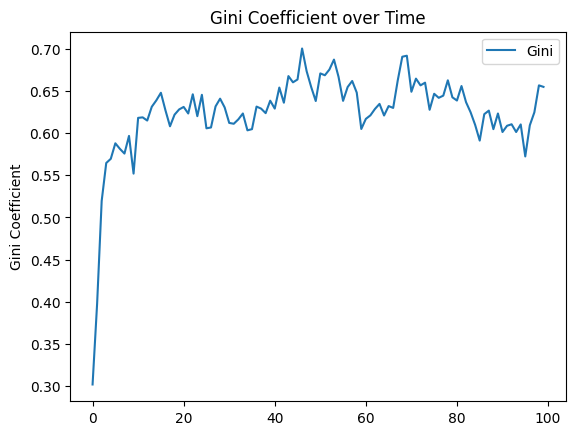

In [37]:
# Plot the Gini coefficient over time
gini = model.datacollector.get_model_vars_dataframe()
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

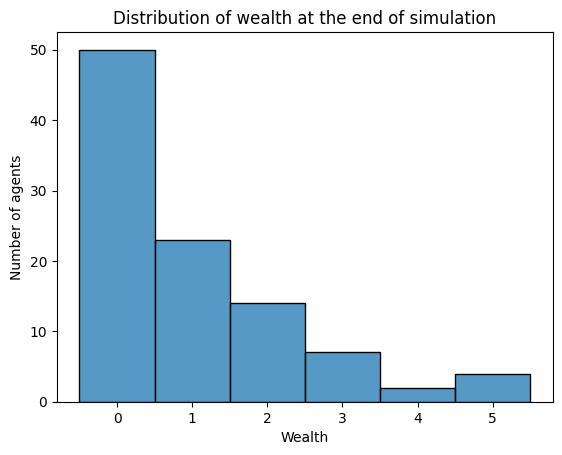

In [38]:
# plot wealth distribution
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()
last_step = agent_wealth.index.get_level_values("Step").max()
end_wealth = agent_wealth.xs(last_step, level="Step")["Wealth"]
# Create a histogram of wealth at the last step
g = sns.histplot(end_wealth, discrete=True)
g.set(
    title="Distribution of wealth at the end of simulation",
    xlabel="Wealth",
    ylabel="Number of agents",
);

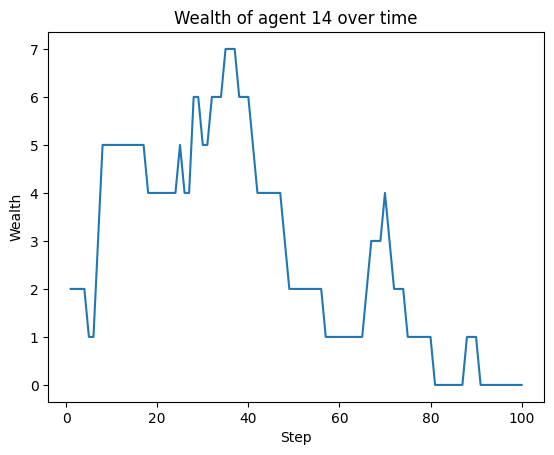

In [39]:
# plot wealth of agent 14 over course of simulation
agent_14_wealth = agent_wealth.xs(14, level = "AgentID")
g = sns.lineplot(data = agent_14_wealth, x = "Step", y = "Wealth")
g.set(title = "Wealth of agent 14 over time");

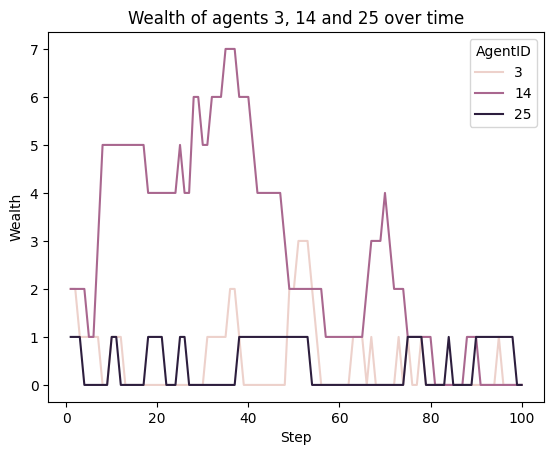

In [40]:
# plot wealth of agents 3, 14, and 25 over time
agent_list = [3, 14, 25]
multiple_agents_wealth = agent_wealth[
    agent_wealth.index.get_level_values("AgentID").isin(agent_list)
]
g = sns.lineplot(data=multiple_agents_wealth, x="Step", y="Wealth", hue="AgentID")
g.set(title="Wealth of agents 3, 14 and 25 over time");

[Text(0.5, 1.0, 'Average wealth over time')]

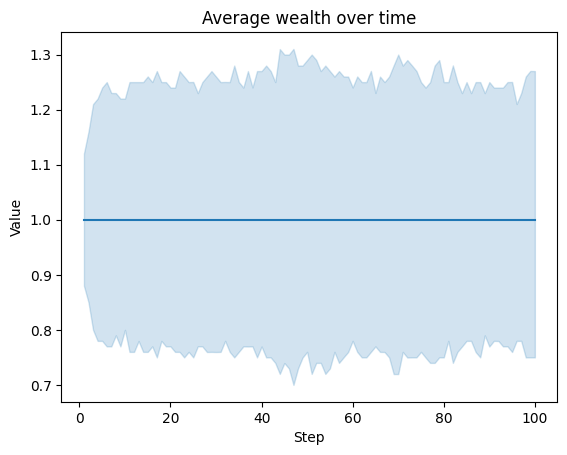

In [43]:
# plot average wealth of all agents with 95% confidence level
agent_wealth_long = agent_wealth.T.unstack().reset_index()
agent_wealth_long.columns = ["Step", "AgentID", "Variable", "Value"]
agent_wealth_long.head(3)

# Plot the average wealth over time
g = sns.lineplot(data=agent_wealth_long, x="Step", y="Value", errorbar=("ci", 95))
g.set(title="Average wealth over time")

In [ ]:
# save the model data (stored in the pandas gini object) to CSV
gini.to_csv("model_data.csv")

# save the agent data (stored in the pandas agent_wealth object) to CSV
agent_wealth.to_csv("agent_data.csv")

In [46]:
# batch run
params = {"width": 10, "height": 10, "N": range(10, 500, 10)}

results = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

results_df = pd.DataFrame(results)
print(results_df.keys())

  0%|          | 0/245 [00:00<?, ?it/s]

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'N', 'Gini', 'AgentID',
       'Wealth'],
      dtype='object')
